# **ABCDEats Inc. - Clustering Analysis: Spending and Order Diversity**

# 1. Imports, Options and Ingestion

In [1]:
# Imports list
import joblib
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

# from matplotlib.patches import RegularPolygon, Ellipse
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib import cm, colorbar
# from matplotlib import colors as mpl_colors
# from matplotlib.colors import LinearSegmentedColormap
# from matplotlib.lines import Line2D
# from matplotlib import __version__ as mplver

In [2]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [3]:
path = '/home/shadybea/OneDrive/General/Data Mining/Project/'

In [4]:
# Reading the csv data
data = pd.read_csv(f'{path}all_customers_preproc.csv', index_col=0)

regulars = pd.read_csv(f'{path}regulars_preproc.csv', index_col=0)

# 2. RFM

In [5]:
# Create a dataframe to perform the RFM analysis
rfm_df = data.copy()

In [6]:
rfm_df['recency'] = 90 - data['last_order']

In [7]:
# Features to use in the RFM
rfm_features = ['recency', 'n_order', 'total_amt']

In [8]:
rfm_df = rfm_df[rfm_features]

In [9]:
# Get the values for R, F and M
rfm_df['r_value'] = pd.qcut(rfm_df['recency'], 3, labels=[1, 2, 3])
rfm_df['f_value'] = pd.qcut(rfm_df['n_order'], 3, labels=[1, 2, 3])
rfm_df['m_value'] = pd.qcut(rfm_df['total_amt'], 3, labels=[1, 2, 3])

In [10]:
rfm_df['rfm_score'] = rfm_df['r_value'].astype('str') + rfm_df['f_value'].astype('str') + rfm_df['m_value'].astype('str')

In [11]:
# Scaling the data
rfm_scaler = StandardScaler().set_output(transform='pandas')
rfm_scaled_ = pd.concat([
    rfm_scaler.fit_transform(rfm_df.drop(columns=['r_value', 'f_value', 'm_value', 'rfm_score']))
    ,rfm_df[['r_value', 'f_value', 'm_value', 'rfm_score']]
], axis=1)

In [12]:
# Creating the dataframe with only the needed features
rfm_scaled = rfm_scaled_[rfm_features]

In [13]:
# Function to calculate R² for a clustering solution
def get_rsq(df, features, label_column):
    """Calculates R² for a clustering solution.
    
    R² = SSb / SSt
    where:
    SSb = between-group sum of squares
    SSt = total sum of squares
    
    Parameters:
    df (DataFrame): The dataframe containing the features and cluster labels
    features (list): List of feature columns to consider
    label_column (str): The column containing the cluster labels
    
    Returns:
    float: R² value indicating homogeneity of the clusters
    """
    # Total Sum of Squares (SSt)
    mean = df[features].mean().values
    sst = np.sum((df[features].values - mean) ** 2)

    # Between-group Sum of Squares (SSb)
    ssb = 0
    for label in df[label_column].unique():
        group = df[df[label_column] == label]
        group_mean = group[features].mean().values
        ssb += len(group) * np.sum((group_mean - mean) ** 2)
        
    # R² Calculation
    r2 = ssb / sst if sst != 0 else 0
    return r2

In [14]:
# # Running R² Calculation for Different Hierarchical Clustering Methods
# hc_methods = ["ward", "complete", "average", "single"]
# max_nclus = 8

# # Initialize an empty list to store R² values for each method
# r2_hc = []

# # Compute R² for each clustering method and range of clusters
# for link in hc_methods:
#     print(link)
#     r2_method = []
#     for i in range(1, max_nclus + 1):  # Loop over cluster counts
#         print(i)
#         cluster = AgglomerativeClustering(n_clusters=i, metric="euclidean", linkage=link)
        
#         # Get cluster labels
#         hclabels = cluster.fit_predict(rfm_scaled)
        
#         # Concatenate the df with the cluster labels
#         df_concat = pd.concat([rfm_scaled, pd.Series(hclabels, name='labels', index=rfm_scaled.index)], axis=1)  
        
#         # Compute R² for the current number of clusters
#         r2_method.append(get_rsq(df_concat, rfm_scaled.columns.tolist(), 'labels'))
    
#     r2_hc.append(r2_method)

# # Convert R² results into a numpy array for easier manipulation
# r2_hc = np.vstack(r2_hc)

In [15]:
# # Plotting the R² values for Hierarchical Clustering Methods
# sns.set()

# # Create a figure for the plot
# fig = plt.figure(figsize=(11, 5))

# # Plot the R² values for each clustering method
# for i, link in enumerate(hc_methods):
#     sns.lineplot(data=r2_hc[i], linewidth=2.5, markers=["o"] * max_nclus, label=link)

# # Finalize the plot
# plt.legend(title="HC Methods", title_fontsize=11)
# plt.xticks(range(1, max_nclus + 1))
# plt.xlabel("Number of Clusters", fontsize=13)
# plt.ylabel("R² Metric", fontsize=13)
# fig.suptitle("$R^2$ Plot for Various Hierarchical Methods", fontsize=21)

# plt.show()

In [16]:
# # Plotting the Dendrogram for Hierarchical Clustering
# # Using the 'ward' method for dendrogram plotting (you can adjust this method)
# linkage_matrix = linkage(rfm_scaled.values, method="ward", metric="euclidean")

# sns.set()
# fig = plt.figure(figsize=(11, 5))
# # Set a threshold for cutting the dendrogram
# y_threshold = 100
# dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
# plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
# plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
# plt.xlabel('Number of Points in Node')
# plt.ylabel(f'Euclidean Distance', fontsize=13)
# plt.show()

In [17]:
# avg_silhouette = []
# for nclus in range(1, 9):
#     # Skip nclus == 1
#     if nclus == 1:
#         continue

#     cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward")
#     hc_labels = cluster.fit_predict(rfm_scaled)

#     # Calculate centroids based on these hierarchical clusters
#     centroids = []
#     for i in range(nclus):
#         cluster_points = rfm_scaled[hc_labels == i]  # Get points belonging to cluster i
#         centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
#         centroids.append(centroid)

#     centroids = np.array(centroids)

#     # Initialize the KMeans object with n_clusters value and the computed centroids
#     kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
#     cluster_labels = kmclust.fit_predict(rfm_scaled)

#     # Calculate the silhouette score
#     silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
#     avg_silhouette.append(silhouette_avg)
#     print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.5066103393892333
For n_clusters = 3, the average silhouette_score is : 0.43428645964272694
For n_clusters = 4, the average silhouette_score is : 0.415754065562995
For n_clusters = 5, the average silhouette_score is : 0.34292603967734375
For n_clusters = 6, the average silhouette_score is : 0.34430832386523513
For n_clusters = 7, the average silhouette_score is : 0.34618731588107055
For n_clusters = 8, the average silhouette_score is : 0.3384279878299234


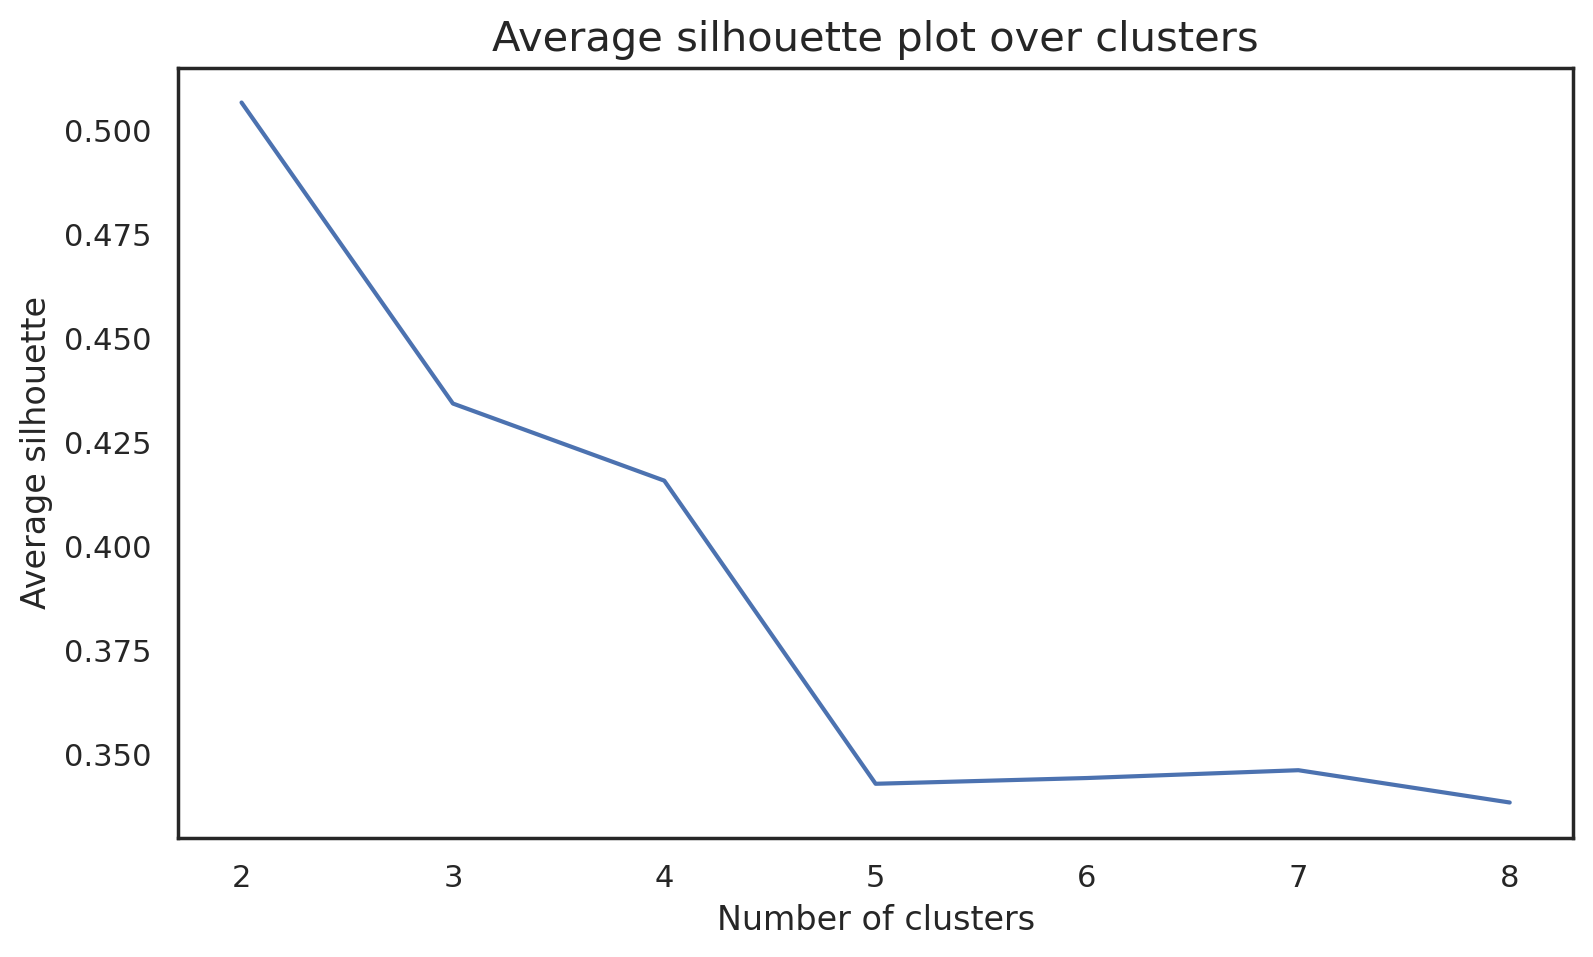

In [18]:
# plt.figure(figsize=(9,5))

# plt.plot(range(2, 9), avg_silhouette)

# plt.ylabel("Average silhouette")
# plt.xlabel("Number of clusters")
# plt.title("Average silhouette plot over clusters", size=15)
# plt.show()

In [19]:
n_clusters = 4

cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(rfm_scaled)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = rfm_scaled[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)


centroids = np.array(centroids)[:n_clusters]

In [20]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(rfm_scaled)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(rfm_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.415754065562995


In [21]:
df_rfm_concat = pd.concat([
    rfm_scaled, 
    pd.Series(hc_labels, name='labels', index=rfm_scaled.index)
    ], 
    axis=1)
df_rfm_concat.groupby('labels').median()

recency   n_order  total_amt
labels                               
0      -0.474131 -0.298879  -0.321598
1      -0.825338  1.120550   1.009184
2       1.457502 -0.535451  -0.618381
3      -0.957040  3.249695   2.284796

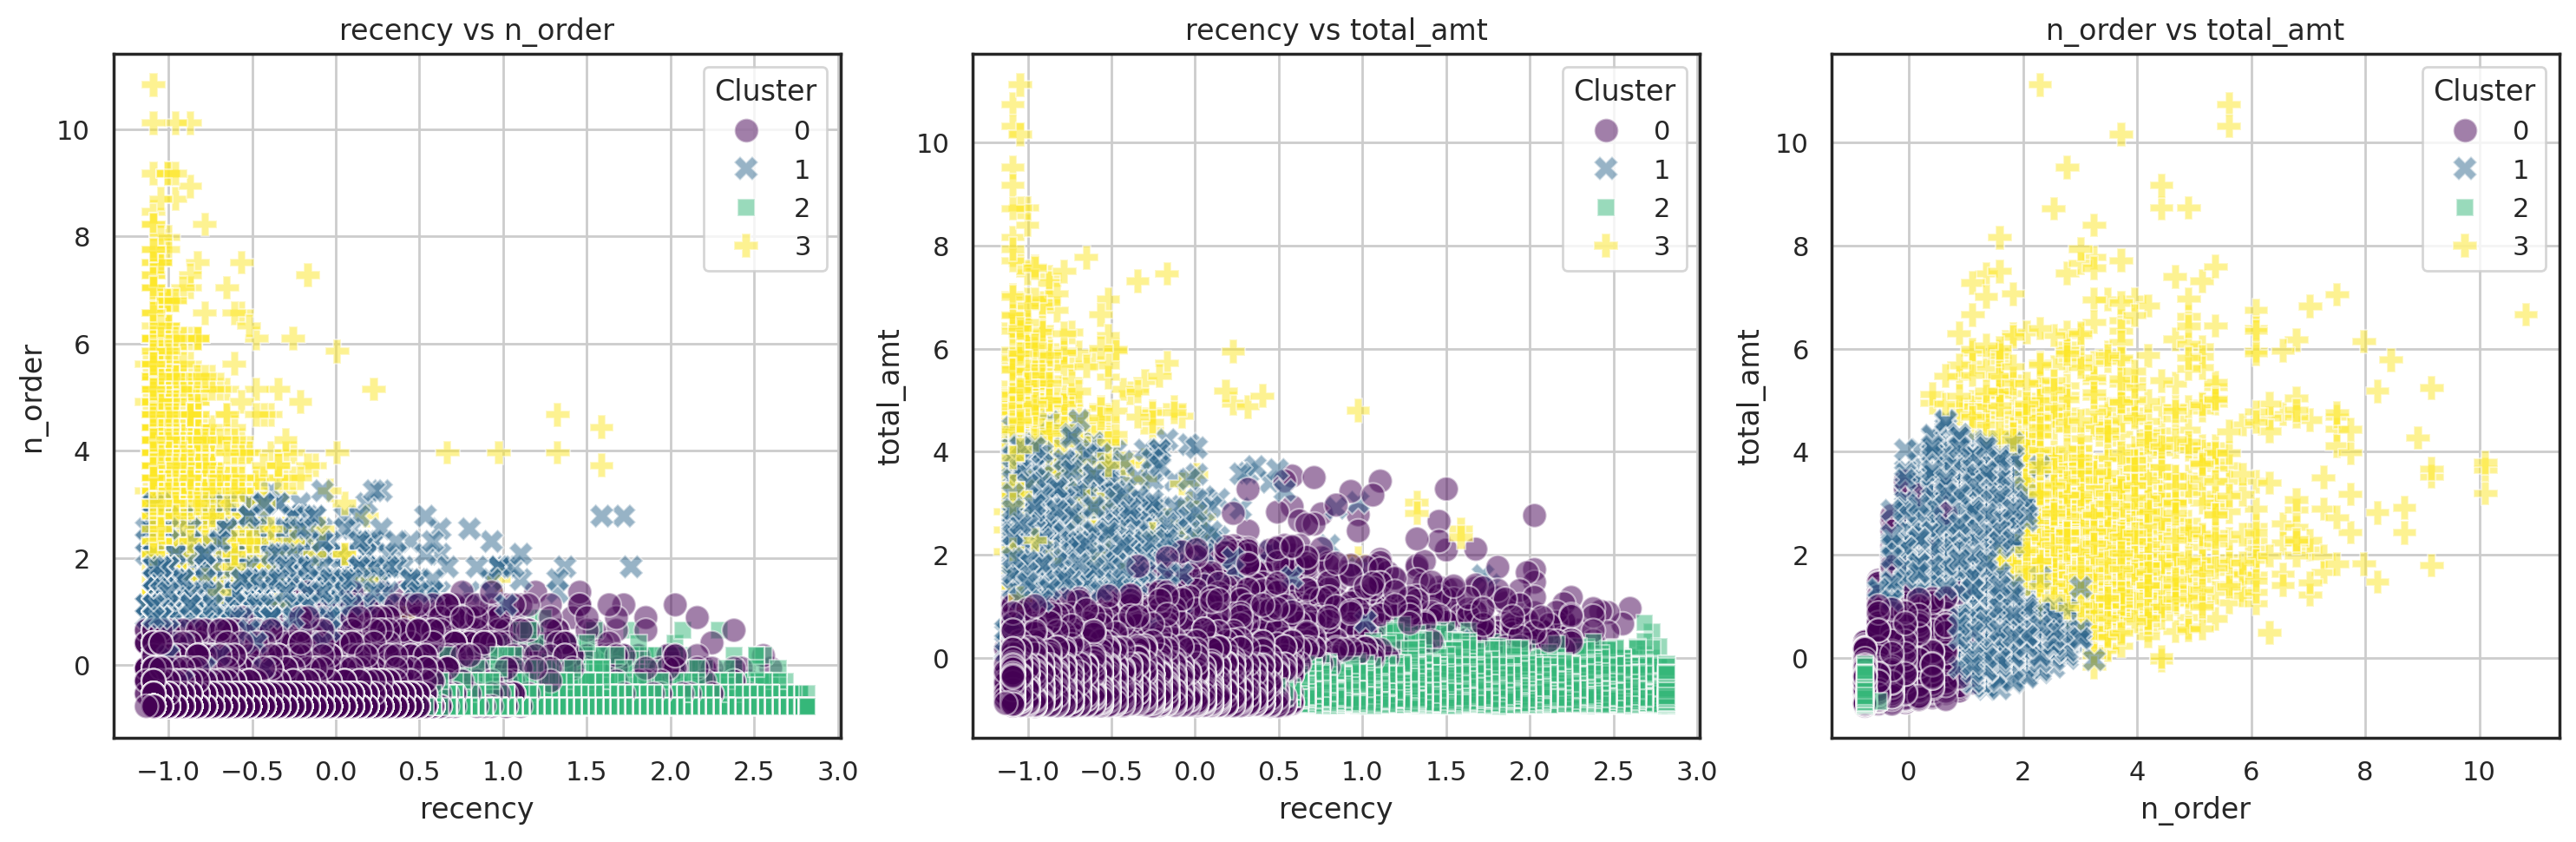

In [22]:
combinations = list(itertools.combinations(df_rfm_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_rfm_concat
        ,x=feature_x
        ,y=feature_y
        ,hue='labels'  # Cluster labels
        ,palette='viridis'
        ,style='labels'
        ,s=100
        ,alpha=0.5
        ,ax=ax
    )

    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

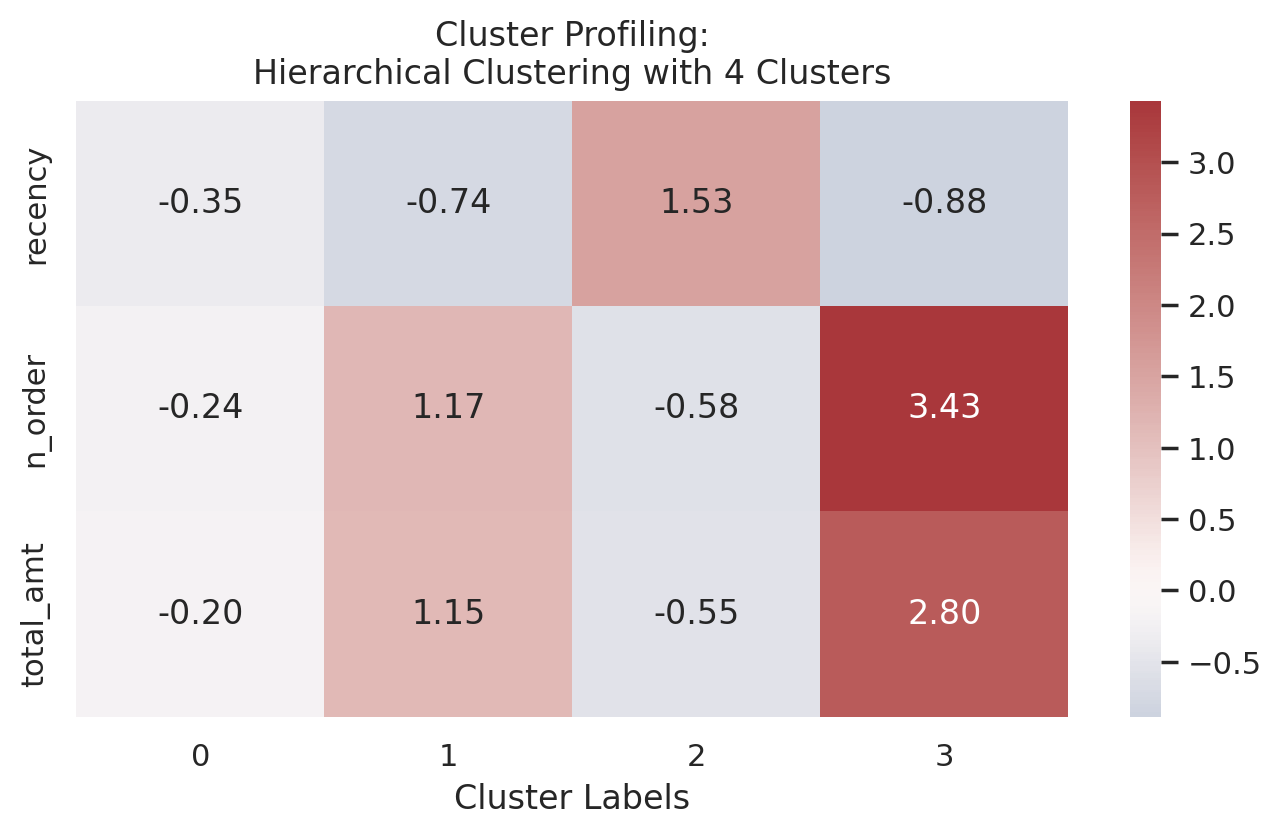

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_rfm_concat.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

## Profiling

In [24]:
rfm_profiling = pd.merge(
    df_rfm_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [25]:
profiling = {
    'Promotion': [col for col in rfm_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in rfm_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in rfm_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in rfm_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in rfm_profiling.columns if col.startswith('age_bucket_')]
}

In [26]:
for profile, cols in profiling.items():
    cluster_profile = rfm_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


labels  last_promo_DELIVERY  last_promo_DISCOUNT  last_promo_FREEBIE  \
0       0             0.148969             0.129621            0.144371   
1       1             0.104862             0.112771            0.130639   
2       2             0.197843             0.145455            0.135593   
3       3             0.096948             0.114004            0.122980   

   last_promo_NO_PROMO  
0             0.577039  
1             0.651728  
2             0.521109  
3             0.666068

Cluster Profiling Based on Payment Method


labels  pay_method_CARD  pay_method_CASH  pay_method_DIGI
0       0         0.701679         0.131409         0.166911
1       1         0.743702         0.105448         0.150849
2       2         0.628043         0.170416         0.201541
3       3         0.754937         0.119390         0.125673

Cluster Profiling Based on City


labels  cust_city_2.0  cust_city_4.0  cust_city_8.0
0       0       0.325522       0.340591       0.333887
1       1       0.380785       0.269186       0.350029
2       2       0.462250       0.281356       0.256394
3       3       0.362657       0.412029       0.225314

Cluster Profiling Based on Region


labels  cust_region_2360.0  cust_region_2400.0  cust_region_4140.0  \
0       0            0.266586            0.058936            0.027137   
1       1            0.305507            0.075278            0.013181   
2       2            0.385824            0.076425            0.024961   
3       3            0.311490            0.051167            0.014363   

   cust_region_4660.0  cust_region_8370.0  cust_region_8550.0  \
0            0.313454            0.013920            0.000319   
1            0.256005            0.010545            0.000293   
2            0.256394            0.009861            0.000000   
3            0.397666            0.003591            0.000000   

   cust_region_8670.0  
0            0.319648  
1            0.339192  
2            0.246533  
3            0.221724

Cluster Profiling Based on Age


labels  age_bucket_15-24  age_bucket_25-34  age_bucket_35-44  \
0       0          0.387523          0.474874          0.108358   
1       1          0.384886          0.479496          0.108670   
2       2          0.391680          0.468413          0.112481   
3       3          0.377917          0.483842          0.105925   

   age_bucket_45-54  age_bucket_55-64  age_bucket_65+  
0          0.023881          0.003767        0.001596  
1          0.021968          0.003808        0.001172  
2          0.020955          0.005239        0.001233  
3          0.023339          0.006284        0.002693

# 3. Spending Diversity Clustering

In [27]:
spending_diversity = ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']

In [28]:
# Creating the dataframe with the needed features
spending_diversity_df = regulars[spending_diversity]

In [29]:
# avg_silhouette = []
# for nclus in range(1, 9):
#     # Skip nclus == 1
#     if nclus == 1:
#         continue

#     cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward")
#     hc_labels = cluster.fit_predict(spending_diversity_df)

#     # Calculate centroids based on these hierarchical clusters
#     centroids = []
#     for i in range(nclus):
#         cluster_points = spending_diversity_df[hc_labels == i]  # Get points belonging to cluster i
#         centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
#         centroids.append(centroid)

#     centroids = np.array(centroids)

#     # Initialize the KMeans object with n_clusters and the computed centroids
#     kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
#     cluster_labels = kmclust.fit_predict(spending_diversity_df)

#     # Calculate the silhouette score
#     silhouette_avg = silhouette_score(spending_diversity_df, cluster_labels)
#     avg_silhouette.append(silhouette_avg)
#     print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.597569509198829
For n_clusters = 3, the average silhouette_score is : 0.4727414753636131
For n_clusters = 4, the average silhouette_score is : 0.3645940203487532
For n_clusters = 5, the average silhouette_score is : 0.3776663181965291
For n_clusters = 6, the average silhouette_score is : 0.3869080522878804
For n_clusters = 7, the average silhouette_score is : 0.38392320786613904
For n_clusters = 8, the average silhouette_score is : 0.3316698760015217


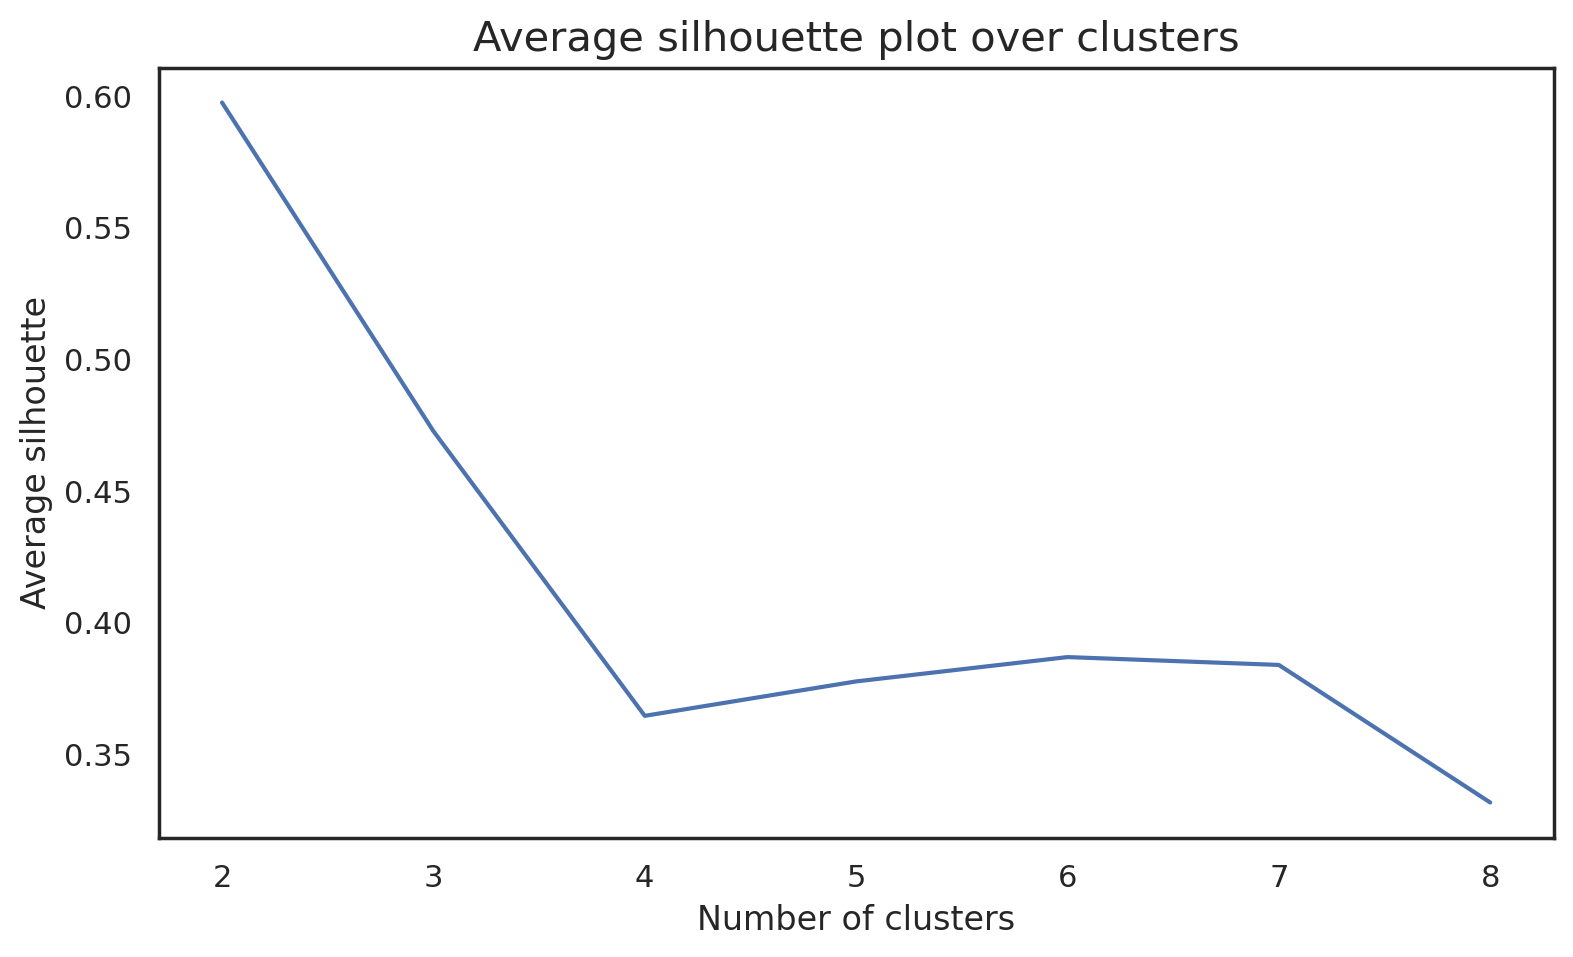

In [30]:
# plt.figure(figsize=(9,5))

# plt.plot(range(2, 9), avg_silhouette)

# plt.ylabel("Average silhouette")
# plt.xlabel("Number of clusters")
# plt.title("Average silhouette plot over clusters", size=15)
# plt.show()

In [31]:
n_clusters = 4

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [32]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3645940203487532


In [33]:
df_sd_concat = pd.concat([
    spending_diversity_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_df.index)
], axis=1)

In [34]:
df_sd_concat.groupby('labels').mean()

total_amt  n_cuisines  n_vendor  n_product
labels                                            
0        0.906840    1.217391  1.131285   0.967829
1        0.007396    0.124234 -0.015317  -0.045163
2        2.399590    2.503635  3.084399   3.273620
3       -0.510344   -0.668610 -0.601943  -0.569988

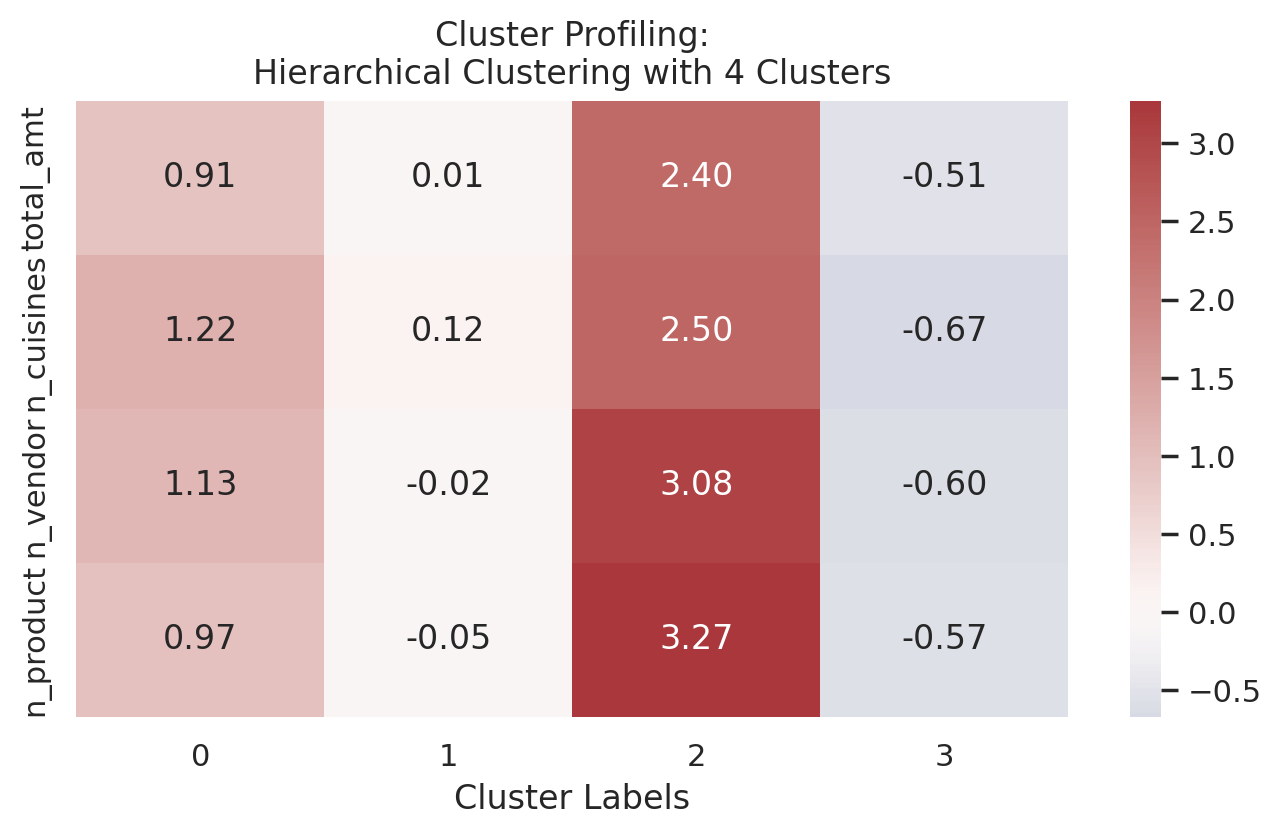

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_sd_concat.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

## Profiling

In [36]:
spending_diversity_profiling = pd.merge(
    df_sd_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [37]:
profiling = {
    'Promotion': [col for col in spending_diversity_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in spending_diversity_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in spending_diversity_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in spending_diversity_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in spending_diversity_profiling.columns if col.startswith('age_bucket_')]
}

In [38]:
for profile, cols in profiling.items():
    cluster_profile = spending_diversity_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


labels  last_promo_DELIVERY  last_promo_DISCOUNT  last_promo_FREEBIE  \
0       0             0.113981             0.118473            0.132229   
1       1             0.126902             0.117561            0.141446   
2       2             0.110112             0.128090            0.120225   
3       3             0.172876             0.139015            0.143280   

   last_promo_NO_PROMO  
0             0.635317  
1             0.614091  
2             0.641573  
3             0.544829

Cluster Profiling Based on Payment Method


labels  pay_method_CARD  pay_method_CASH  pay_method_DIGI
0       0         0.738911         0.109770         0.151319
1       1         0.721777         0.122631         0.155591
2       2         0.764045         0.113483         0.122472
3       3         0.669046         0.147371         0.183583

Cluster Profiling Based on City


labels  cust_city_2.0  cust_city_4.0  cust_city_8.0
0       0       0.403144       0.281303       0.315553
1       1       0.363224       0.304110       0.332666
2       2       0.552809       0.248315       0.198876
3       3       0.317897       0.358896       0.323207

Cluster Profiling Based on Region


labels  cust_region_2360.0  cust_region_2400.0  cust_region_4140.0  \
0       0            0.324537            0.078608            0.008141   
1       1            0.297171            0.066053            0.016413   
2       2            0.470787            0.082022            0.004494   
3       3            0.262448            0.055449            0.035776   

   cust_region_4660.0  cust_region_8370.0  cust_region_8550.0  \
0            0.273161            0.008703            0.000000   
1            0.287697            0.010942            0.000400   
2            0.243820            0.002247            0.000000   
3            0.323120            0.015233            0.000261   

   cust_region_8670.0  
0            0.306850  
1            0.321324  
2            0.196629  
3            0.307712

Cluster Profiling Based on Age


labels  age_bucket_15-24  age_bucket_25-34  age_bucket_35-44  \
0       0          0.386019          0.475014          0.112296   
1       1          0.383240          0.477048          0.109554   
2       2          0.377528          0.491011          0.098876   
3       3          0.391017          0.472580          0.108113   

   age_bucket_45-54  age_bucket_55-64  age_bucket_65+  
0          0.023302          0.002527        0.000842  
1          0.022952          0.005338        0.001868  
2          0.022472          0.007865        0.002247  
3          0.023329          0.003482        0.001480

# 4. Head to Head

In [39]:
df_final_concat = pd.concat([
    df_rfm_concat.rename(columns={'labels': 'rfm_labels'})
    ,df_sd_concat.rename(columns={'labels': 'spending_labels'})
], axis=1)

In [40]:
df_final_concat.dropna(subset=['spending_labels'], inplace=True)

## RFM vs Spending

In [41]:
rfm_spending_prop = pd.DataFrame(
    df_final_concat.groupby(['rfm_labels', 'spending_labels']).size()  / df_final_concat.shape[0]
).reset_index()

In [42]:
rfm_spending_prop.rename(columns={0: 'Total Proportion'}, inplace=True)

In [43]:
rfm_spending_prop['Proportion_within_rfm_labels'] = rfm_spending_prop.groupby('rfm_labels')['Total Proportion'].transform(lambda x: x / x.sum())

In [44]:
rfm_spending_prop

rfm_labels  spending_labels  Total Proportion  \
0            0              0.0          0.037638   
1            0              1.0          0.256721   
2            0              2.0          0.000043   
3            0              3.0          0.373901   
4            1              0.0          0.099129   
5            1              1.0          0.038320   
6            1              2.0          0.007297   
7            1              3.0          0.000939   
8            2              0.0          0.000683   
9            2              1.0          0.022403   
10           2              3.0          0.115388   
11           3              0.0          0.014552   
12           3              1.0          0.002347   
13           3              2.0          0.030639   

    Proportion_within_rfm_labels  
0                       0.056318  
1                       0.384139  
2                       0.000064  
3                       0.559479  
4                       0.680434  
5                       0.263035  
6                       0.050088  
7                       0.006444  
8                       0.004931  
9                       0.161787  
10                      0.833282  
11                      0.306104  
12                      0.049372  
13                      0.644524

## Spending vs RFM

In [45]:
spending_rfm_prop = pd.DataFrame(
    df_final_concat.groupby(['spending_labels', 'rfm_labels']).size() / df_final_concat.shape[0]
).reset_index()

In [46]:
spending_rfm_prop.rename(columns={0: 'Total Proportion'}, inplace=True)

In [47]:
spending_rfm_prop['Proportion_within_spending_labels'] = spending_rfm_prop.groupby('spending_labels')['Total Proportion'].transform(lambda x: x / x.sum())

In [48]:
spending_rfm_prop

spending_labels  rfm_labels  Total Proportion  \
0               0.0           0          0.037638   
1               0.0           1          0.099129   
2               0.0           2          0.000683   
3               0.0           3          0.014552   
4               1.0           0          0.256721   
5               1.0           1          0.038320   
6               1.0           2          0.022403   
7               1.0           3          0.002347   
8               2.0           0          0.000043   
9               2.0           1          0.007297   
10              2.0           3          0.030639   
11              3.0           0          0.373901   
12              3.0           1          0.000939   
13              3.0           2          0.115388   

    Proportion_within_spending_labels  
0                            0.247614  
1                            0.652162  
2                            0.004492  
3                            0.095733  
4                            0.802776  
5                            0.119829  
6                            0.070056  
7                            0.007339  
8                            0.001124  
9                            0.192135  
10                           0.806742  
11                           0.762709  
12                           0.001915  
13                           0.235376

## Removing Customers

Looking at the above tables, we see that the customers belonging to cluster 3 of the Spending clustering and to cluster 0 of the RFM clustering are the most representative group. Analysing these clusters, we know that these are the customers that interact the least with the business. Therefore, we decide to remove these customers from our analysis and will perform the Spending clustering once again, in order to obtain a final solution.

In [49]:
# Get the indices of customers which will be removed
customers = df_final_concat[(
    (df_final_concat['rfm_labels'] == 0) & (df_final_concat['spending_labels'] == 3)
)].index

In [50]:
# Number of customers excluded from the analysis
len(customers)

8762

# 5. (New) Spending Diversity Clustering

In [51]:
# Create a new dataframe without the identified customers
spending_diversity_after_df = spending_diversity_df.drop(index=customers)

In [52]:
# Rescaling the data
after_scaler = StandardScaler().set_output(transform='pandas')
spending_diversity_after_df = after_scaler.fit_transform(spending_diversity_after_df)

In [53]:
# avg_silhouette = []
# for nclus in range(3, 9):
#     # Skip nclus == 1
#     if nclus == 1:
#         continue

#     cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
#     hc_labels = cluster.fit_predict(spending_diversity_after_df)

#     # Calculate centroids based on these hierarchical clusters
#     centroids = []
#     for i in range(nclus):
#         cluster_points = spending_diversity_after_df[hc_labels == i]  # Get points belonging to cluster i
#         centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
#         centroids.append(centroid)

#     centroids = np.array(centroids)

#     # Initialize the KMeans object with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
#     cluster_labels = kmclust.fit_predict(spending_diversity_after_df)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed clusters
#     silhouette_avg = silhouette_score(spending_diversity_after_df, cluster_labels)
#     avg_silhouette.append(silhouette_avg)
#     print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 3, the average silhouette_score is : 0.38182337755607404
For n_clusters = 4, the average silhouette_score is : 0.36598980789996033
For n_clusters = 5, the average silhouette_score is : 0.31859373074445185
For n_clusters = 6, the average silhouette_score is : 0.32856966735129134
For n_clusters = 7, the average silhouette_score is : 0.32399031159760433
For n_clusters = 8, the average silhouette_score is : 0.33831433884805273


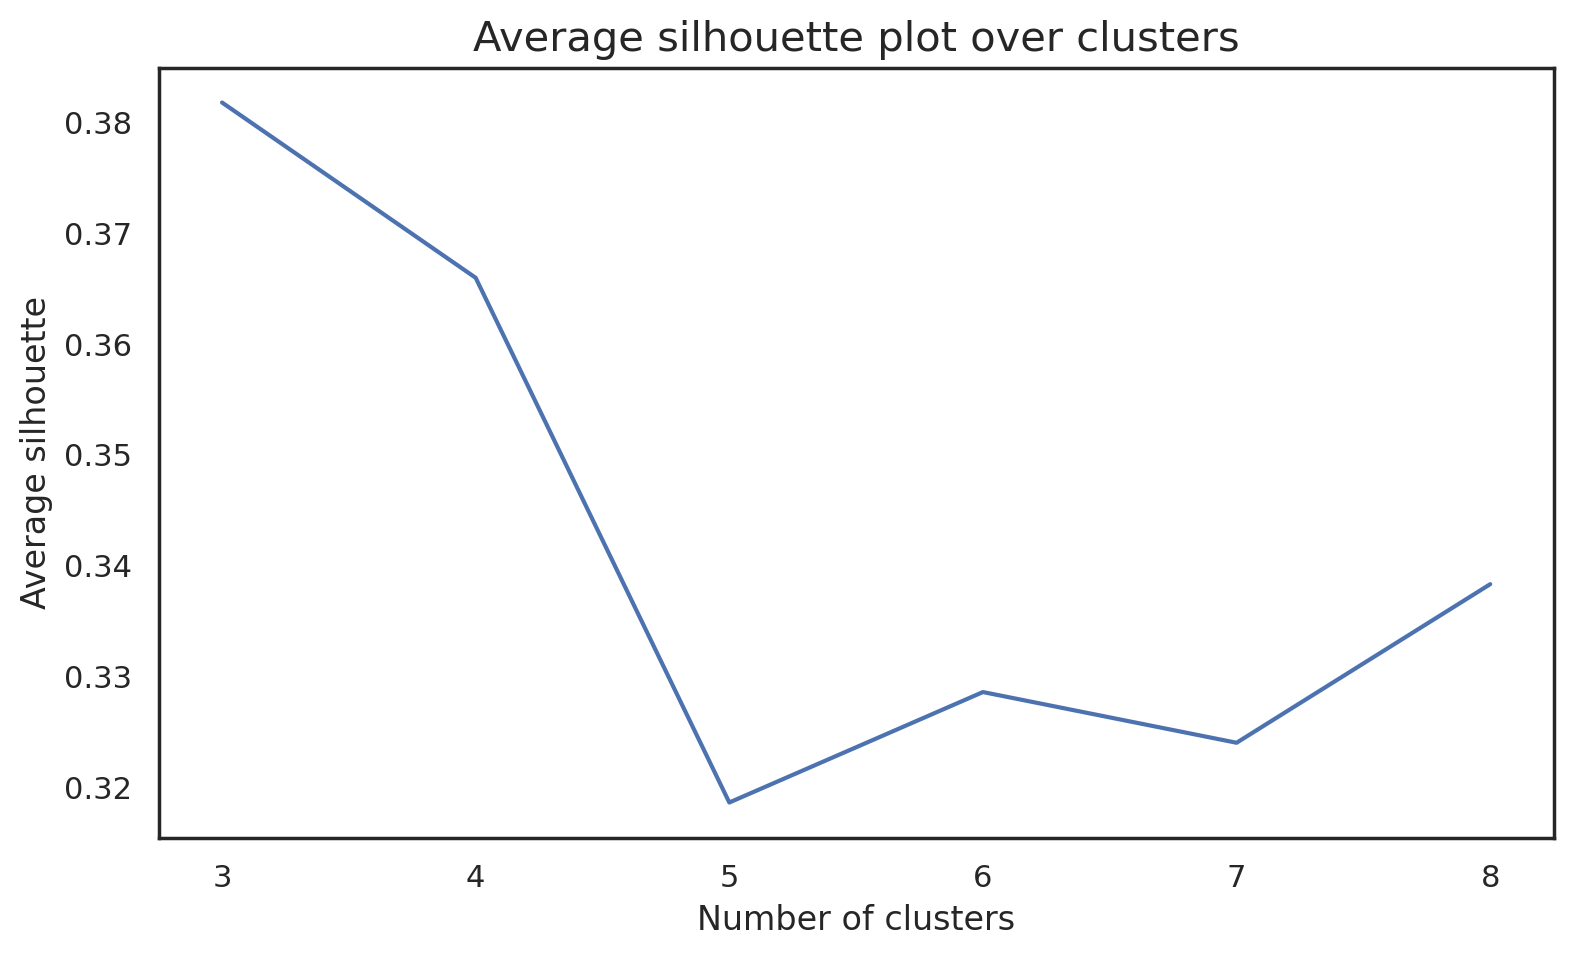

In [54]:
# # The average silhouette plot
# # The inertia plot
# plt.figure(figsize=(9,5))


# #  Why range_clusters[1:] ? 
# # Remember we skipped k=1 in the cell above

# plt.plot(range(3, 9), ## Plot X-axis; 
#          avg_silhouette)     ## Plot Y-axis

# plt.ylabel("Average silhouette")
# plt.xlabel("Number of clusters")
# plt.title("Average silhouette plot over clusters", size=15)
# plt.show()

In [55]:
n_clusters = 4

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_after_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_after_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [56]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_after_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_after_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.36598980789996033


In [57]:
df_concat = pd.concat([
    spending_diversity_after_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_after_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean()

total_amt  n_cuisines  n_vendor  n_product
labels                                            
0        1.522619    1.970927  2.311330   2.257456
1        1.266394    0.153897  0.478068   0.777044
2       -0.403955   -0.578906 -0.566696  -0.532380
3       -0.335209    0.711813  0.316200   0.042684

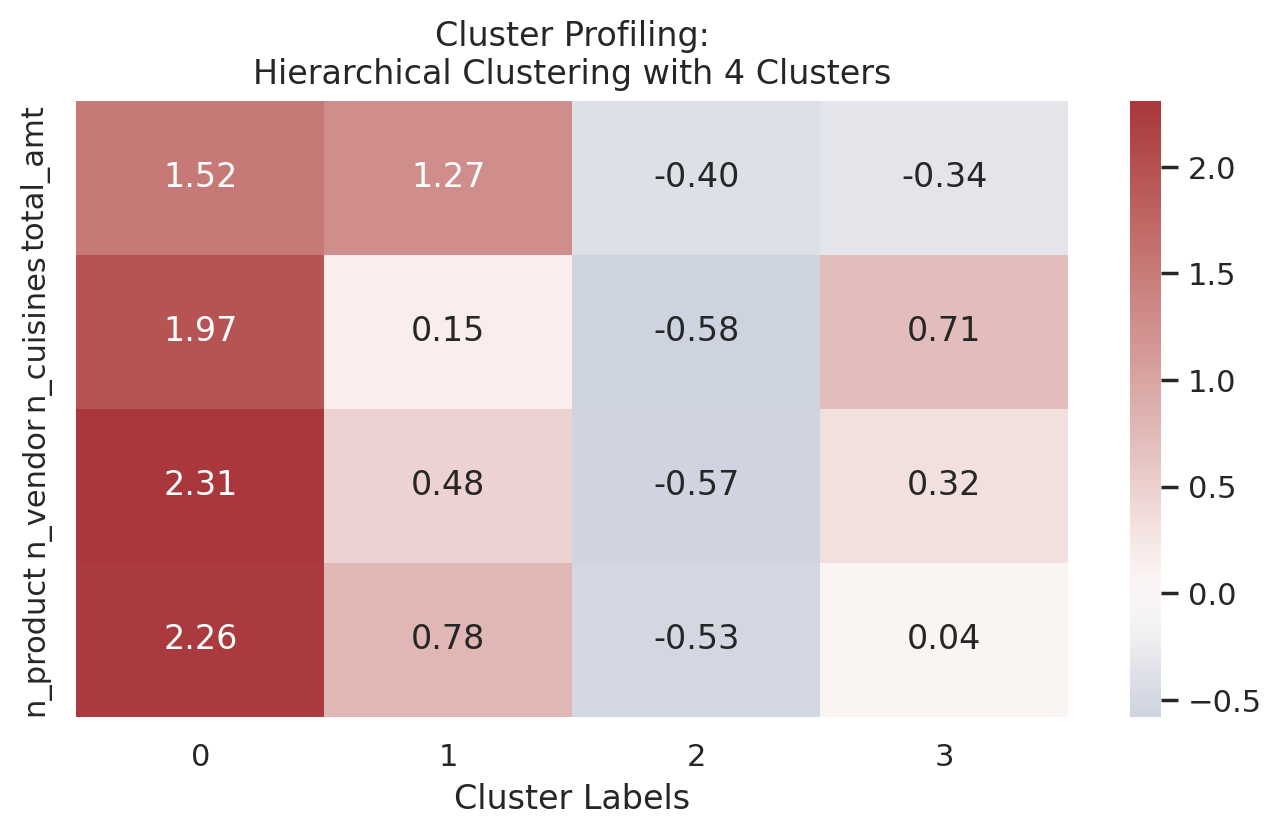

In [58]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

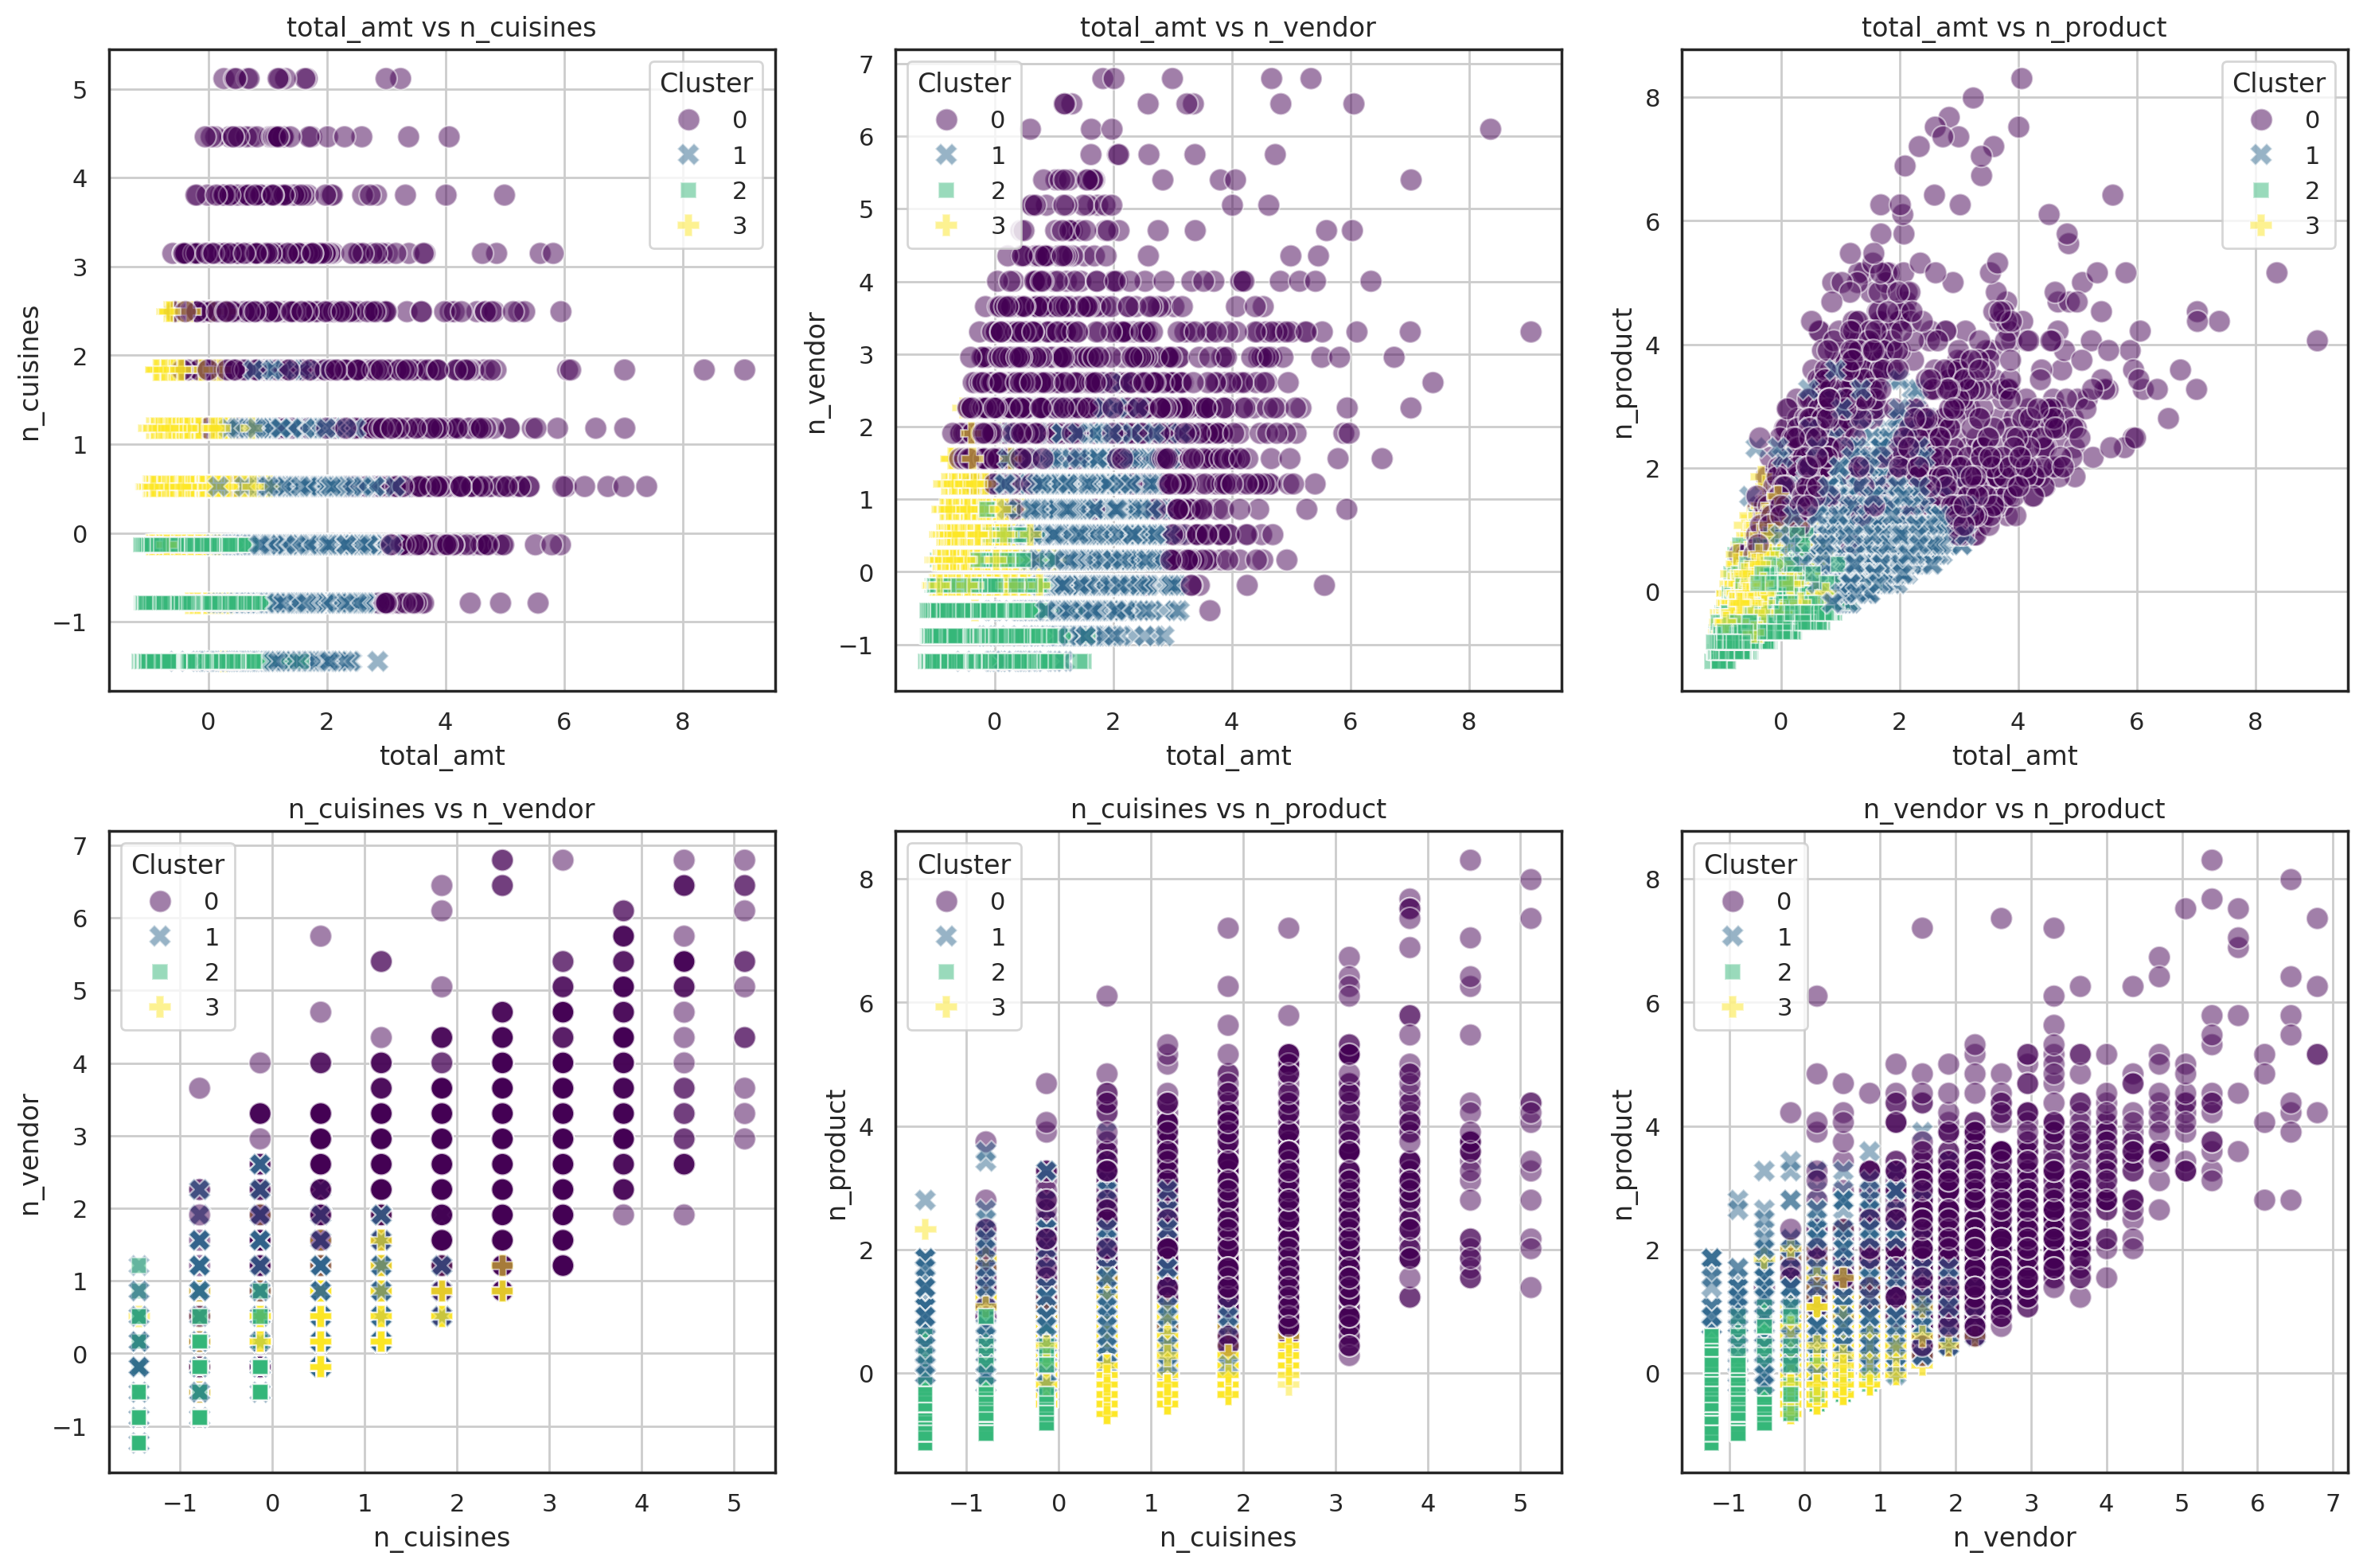

In [59]:
combinations = list(itertools.combinations(df_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.5,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

## Scoring

In [60]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_concat.drop(columns='labels'))  # get total sum of squares
ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

/tmp/ipykernel_11673/2576853450.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels


0.6373257545071019

## Profiling

In [61]:
sd_after_profiling = pd.merge(
    df_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [62]:
profiling = {
    'Promotion': [col for col in sd_after_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in sd_after_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in sd_after_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in sd_after_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in sd_after_profiling.columns if col.startswith('age_bucket_')]
}

In [63]:
for profile, col in profiling.items():
    cluster_profile = sd_after_profiling.groupby('labels')[col].mean()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


last_promo_DELIVERY  last_promo_DISCOUNT  last_promo_FREEBIE  \
labels                                                                 
0                  0.106551             0.129440            0.120758   
1                  0.094656             0.089059            0.126209   
2                  0.152748             0.126327            0.139774   
3                  0.132681             0.138420            0.143484   

        last_promo_NO_PROMO  
labels                       
0                  0.643252  
1                  0.690076  
2                  0.581151  
3                  0.585415

Cluster Profiling Based on Payment Method


pay_method_CARD  pay_method_CASH  pay_method_DIGI
labels                                                   
0              0.758485         0.112865         0.128650
1              0.747074         0.109415         0.143511
2              0.692262         0.140363         0.167374
3              0.716408         0.111749         0.171843

Cluster Profiling Based on City


cust_city_2.0  cust_city_4.0  cust_city_8.0
labels                                             
0            0.618785       0.182320       0.198895
1            0.060051       0.384733       0.555216
2            0.335103       0.320477       0.344421
3            0.685348       0.214720       0.099932

Cluster Profiling Based on Region


cust_region_2360.0  cust_region_2400.0  cust_region_4140.0  \
labels                                                               
0                 0.513023            0.105762            0.002368   
1                 0.050382            0.009669            0.019847   
2                 0.274711            0.060392            0.020760   
3                 0.559082            0.126266            0.005739   

        cust_region_4660.0  cust_region_8370.0  cust_region_8550.0  \
labels                                                               
0                 0.179953            0.001579            0.000000   
1                 0.364885            0.016794            0.000509   
2                 0.299717            0.012149            0.000236   
3                 0.208980            0.003038            0.000000   

        cust_region_8670.0  
labels                      
0                 0.197316  
1                 0.537913  
2                 0.332036  
3                 0.096894

Cluster Profiling Based on Age


age_bucket_15-24  age_bucket_25-34  age_bucket_35-44  \
labels                                                         
0               0.385162          0.476717          0.108919   
1               0.380153          0.483969          0.109415   
2               0.384289          0.474640          0.111583   
3               0.390952          0.475692          0.104997   

        age_bucket_45-54  age_bucket_55-64  age_bucket_65+  
labels                                                      
0               0.021310          0.007103        0.000789  
1               0.022392          0.002036        0.002036  
2               0.022175          0.005544        0.001769  
3               0.024308          0.003376        0.000675

## Explaining the Clusters

In [64]:
# Load the scaler
scaler = joblib.load('std_scaler.pkl')

In [65]:
numeric = [
    'cust_age', 'n_vendor', 'n_product', 'n_chain', 'first_order',
    'last_order', 'american', 'asian', 'beverages', 'cafe',
    'chicken_dishes', 'chinese', 'desserts', 'healthy', 'indian', 'italian',
    'japanese', 'noodle_dishes', 'other', 'street_food_snacks', 'thai',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0',
    'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
    'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
    'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_amt',
    'n_order', 'avg_amt_per_product', 'avg_amt_per_order',
    'avg_amt_per_vendor', 'days_cust', 'avg_days_to_order', 'days_due',
    'per_chain_order', 'n_days_week', 'n_times_day', 'n_cuisines',
    'log_n_vendor', 'log_n_product', 'log_n_chain', 'log_american',
    'log_asian', 'log_beverages', 'log_cafe', 'log_chicken_dishes',
    'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
    'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
    'log_street_food_snacks', 'log_thai', 'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]

In [66]:
aux_unscaled_df = pd.DataFrame(scaler.inverse_transform(regulars[numeric]), columns=numeric, index=regulars.index)

In [67]:
indices = df_concat.index

In [68]:
aux_unscaled_df = aux_unscaled_df.loc[indices]

In [69]:
for col in ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']:
    df_concat[col] = aux_unscaled_df[col]

In [70]:
df_concat.groupby('labels').agg(['min', 'max', 'mean'])

total_amt                     n_cuisines                 n_vendor  \
             min     max        mean        min   max      mean      min   
labels                                                                     
0          21.15  458.56  121.100497        2.0  11.0  6.205998      3.0   
1          29.16  200.90  109.602870        1.0   7.0  3.436641      1.0   
2           0.47  123.49   34.649033        1.0   3.0  2.319769      1.0   
3           5.15  105.98   37.733889        1.0   7.0  4.286968      3.0   

                        n_product                   
         max       mean       min   max       mean  
labels                                              
0       24.0  11.154696      10.0  61.0  22.569061  
1       12.0   5.900763       7.0  33.0  13.161323  
2        8.0   2.906582       1.0  16.0   4.840175  
3       11.0   5.436867       4.0  23.0   8.494598

**Cluster 1: Foodies**
- These customers are high spenders who explore a variety of cuisines and vendors.
- They order a large number of products, showcasing a love for trying new and different food experiences.
- They mostly belong to region 2360.

**Cluster 2: Routineers**
- These customers spend less, stick to familiar dishes and vendors and place small orders.
- They are loyal to their go-to meals and vendors.

**Cluster 3: Moderates**
- These customers strike a balance between exploration and routine.
- They have moderate spending habits, ocassionally try new cuisines and vendors, and place average-sized orders.
- They represent the casual customers who enjoy variety without overindulging.